## 流程

导入成功: 20558 条数据
时间范围: 2024-08-29 09:50:00 → 2025-09-23 16:00:00

数据预览:
   Symbol     Name     open     high      low    close  pct_chg  amount  \
0  SPX.GI  S&P 500  5610.77  5618.12  5607.34  5609.18  -0.0003       0   
1  SPX.GI  S&P 500  5608.86  5618.62  5604.53  5618.14   0.0016       0   
2  SPX.GI  S&P 500  5618.71  5628.69  5610.56  5628.27   0.0018       0   

             datetime  
0 2024-08-29 09:50:00  
1 2024-08-29 09:55:00  
2 2024-08-29 10:00:00  

数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20558 entries, 0 to 20557
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Symbol    20558 non-null  object        
 1   Name      20558 non-null  object        
 2   open      20558 non-null  float64       
 3   high      20558 non-null  float64       
 4   low       20558 non-null  float64       
 5   close     20558 non-null  float64       
 6   pct_chg   20558 non-null  float64       
 7 

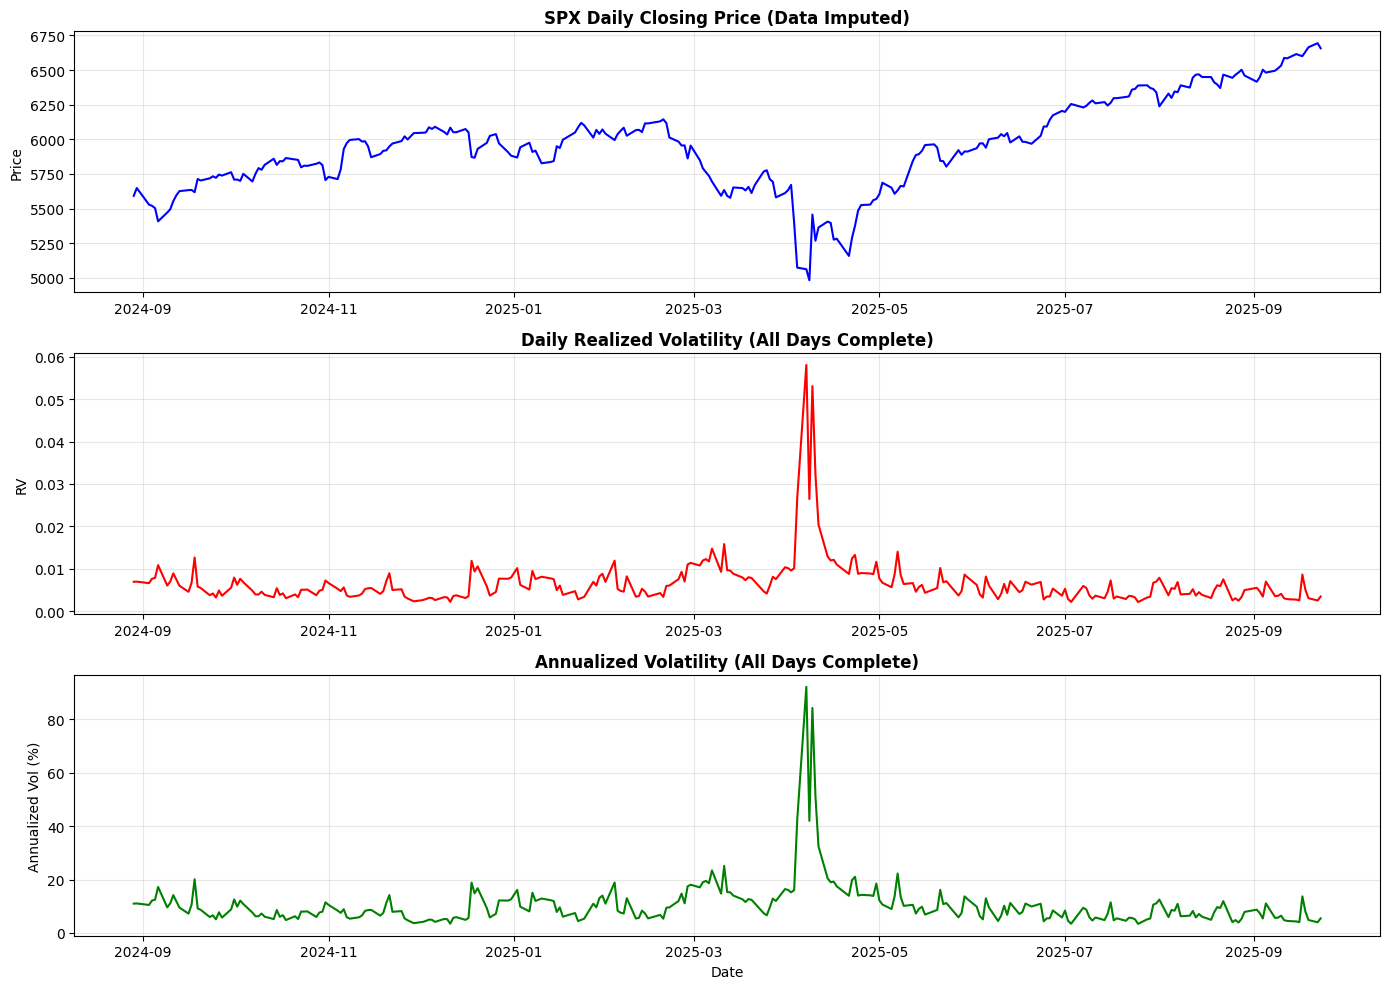

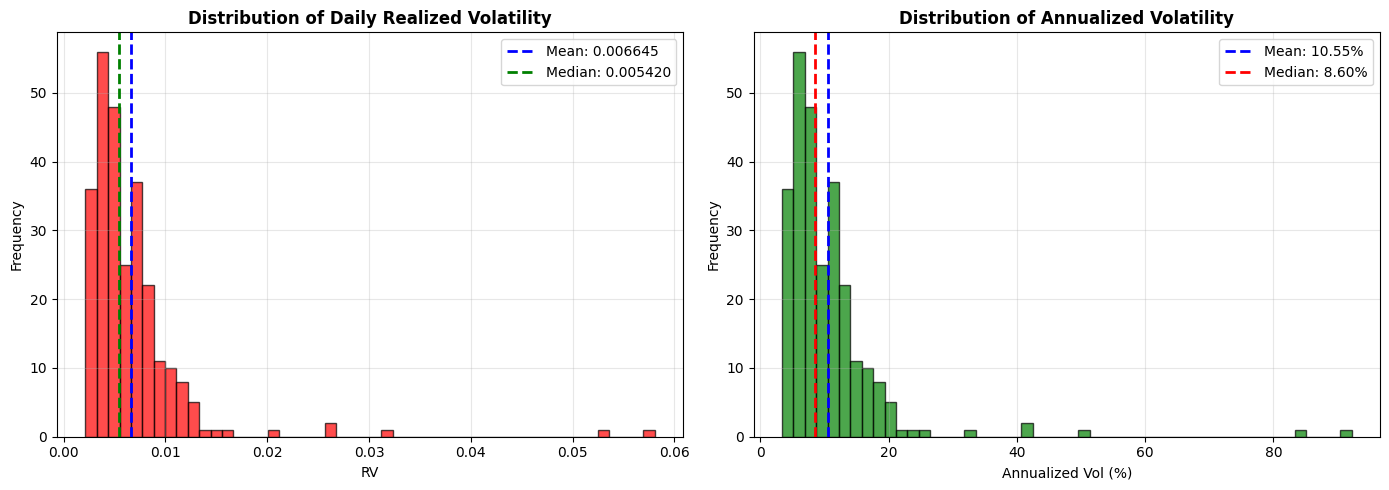


数据导出

✓ 日度波动率数据已保存到: ../result/SPX_daily_volatility.csv

保存的数据包含以下列:
  1. date
  2. realized_volatility
  3. n_obs
  4. open
  5. high
  6. low
  7. close
  8. first_time
  9. last_time
  10. daily_return
  11. annualized_volatility

数据形状: (267, 11) (行, 列)
  所有 267 天的数据都是完整的 (78个数据点/天)

前5行数据:
         date  realized_volatility  n_obs     open     high      low    close  \
0  2024-08-29             0.006922     78  5610.77  5646.90  5583.71  5591.96   
1  2024-08-30             0.006963     78  5612.74  5650.94  5581.79  5648.40   
2  2024-09-03             0.006606     78  5623.89  5623.89  5504.33  5528.93   
3  2024-09-04             0.007650     78  5506.70  5552.99  5503.66  5520.07   
4  2024-09-05             0.007846     78  5520.08  5546.29  5480.54  5503.41   

           first_time           last_time  daily_return  annualized_volatility  
0 2024-08-29 09:35:00 2024-08-29 16:00:00           NaN               0.109888  
1 2024-08-30 09:35:00 2024-08-30 16:00:00      0.010042

In [2]:
import pandas as pd
import numpy as np

# 1. 读取SPX数据文件
filepath = r'..\data\SPX-20240923-20250923-5min.csv'
df = pd.read_csv(filepath)

# 2. 列名标准化（处理原始列名和尾随逗号产生的空列）
# 原始列: Symbol,Name,Date,open,Highest Price,Lowest Price,Closing Price,% Chg (D),Amount (CNY1M),
df.columns = [
    'Symbol', 'Name', 'Date', 'open', 'high', 'low', 
    'close', 'pct_chg', 'amount', 'empty'
]

# 3. 删除空列
df = df.drop(columns=['empty'])

# 4. 转换时间格式并排序
df['datetime'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M')
df = df.drop(columns='Date').sort_values('datetime').reset_index(drop=True)

# 5. 数据类型转换
numeric_cols = ['open', 'high', 'low', 'close', 'pct_chg', 'amount']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 6. 检查数据
print(f"导入成功: {len(df)} 条数据")
print(f"时间范围: {df['datetime'].min()} → {df['datetime'].max()}")
print(f"\n数据预览:")
print(df.head(3))
print(f"\n数据信息:")
print(df.info())
print(f"\n统计摘要:")
print(df[['open', 'high', 'low', 'close']].describe())
# 1. 添加日期列，用于分组
df['date'] = df['datetime'].dt.date

# 2. 检查每天的数据点数量
daily_counts = df.groupby('date').size()
print("每天数据点数量统计:")
print(f"最小值: {daily_counts.min()}")
print(f"最大值: {daily_counts.max()}")
print(f"平均值: {daily_counts.mean():.2f}")
print(f"中位数: {daily_counts.median()}")
print(f"\n数据点数量分布:")
print(daily_counts.value_counts().sort_index())

# 3. 查看不完整的天数（假设完整的一天应该有78个数据点：09:35-16:00，每5分钟一个）
# 从09:35到16:00: (16*60+0) - (9*60+35) = 960 - 575 = 385分钟 / 5 = 77个间隔 + 1 = 78个点
incomplete_days = daily_counts[daily_counts < 70]  # 少于70个点的视为不完整
print(f"\n不完整的天数 (少于70个数据点): {len(incomplete_days)} 天")
if len(incomplete_days) > 0:
    print(incomplete_days)
# 补全缺失数据 - 为所有天创建完整的时间网格
print("=" * 80)
print("开始补全缺失数据")
print("=" * 80)

# 1. 创建完整的时间网格函数
def create_full_time_grid(date):
    """
    为指定日期创建完整的5分钟时间网格（09:35-16:00）
    """
    from datetime import datetime, timedelta
    
    start_time = datetime.combine(date, datetime.strptime("09:35", "%H:%M").time())
    end_time = datetime.combine(date, datetime.strptime("16:00", "%H:%M").time())
    
    time_grid = []
    current_time = start_time
    while current_time <= end_time:
        time_grid.append(current_time)
        current_time += timedelta(minutes=5)
    
    return time_grid

# 2. 获取所有交易日
all_dates = df['date'].unique()
print(f"\n总交易日数: {len(all_dates)}")

# 3. 为每个交易日创建完整的时间网格
complete_time_grid = []
for date in all_dates:
    complete_time_grid.extend(create_full_time_grid(date))

# 4. 创建完整的数据框架
df_complete = pd.DataFrame({'datetime': complete_time_grid})
df_complete['date'] = df_complete['datetime'].dt.date

# 5. 合并原始数据（左连接，保留所有时间点）
df_complete = df_complete.merge(
    df[['datetime', 'Symbol', 'Name', 'open', 'high', 'low', 'close', 'pct_chg', 'amount']], 
    on='datetime', 
    how='left'
)

# 6. 填充Symbol和Name（这些是常量）
df_complete['Symbol'] = df_complete['Symbol'].fillna('SPX.GI')
df_complete['Name'] = df_complete['Name'].fillna('S&P 500')

# 7. 统计补全前后的数据点
original_points = len(df)
complete_points = len(df_complete)
filled_points = df_complete[['open', 'high', 'low', 'close']].isnull().sum().sum() / 4

print(f"\n数据补全统计:")
print(f"  原始数据点: {original_points}")
print(f"  完整网格点: {complete_points}")
print(f"  需要填充的点: {int(filled_points)}")
print(f"  填充比例: {filled_points/complete_points*100:.2f}%")

# 8. 使用线性插值填充价格数据
print("\n正在使用线性插值填充缺失的价格数据...")
price_cols = ['open', 'high', 'low', 'close']

# 对每一列进行插值
for col in price_cols:
    df_complete[col] = df_complete[col].interpolate(method='linear', limit_direction='both')

# 9. 填充其他列
df_complete['pct_chg'] = df_complete['pct_chg'].fillna(0)  # 填充的数据点收益率设为0
df_complete['amount'] = df_complete['amount'].fillna(0)

# 10. 验证补全结果
print("\n补全后的数据检查:")
print(f"  缺失值数量: {df_complete.isnull().sum().sum()}")

# 检查每天的数据点数量
daily_counts_complete = df_complete.groupby('date').size()
print(f"\n每天数据点数量 (补全后):")
print(f"  最小值: {daily_counts_complete.min()}")
print(f"  最大值: {daily_counts_complete.max()}")
print(f"  平均值: {daily_counts_complete.mean():.2f}")
print(f"  标准差: {daily_counts_complete.std():.2f}")

# 所有天都应该是78个点
if (daily_counts_complete == 78).all():
    print("\n✓ 所有交易日现在都有完整的78个数据点！")
else:
    print(f"\n⚠ 仍有 {(daily_counts_complete != 78).sum()} 天数据点不是78个")
    print(daily_counts_complete.value_counts().sort_index())

print("\n数据预览 (补全后):")
print(df_complete.head(10))

# 使用补全后的数据计算日度已实现波动率 (Realized Volatility)
# RV = sqrt(sum(r_t^2)) where r_t = log(P_t / P_{t-1})

print("\n" + "=" * 80)
print("计算日度已实现波动率 (基于补全后的完整数据)")
print("=" * 80)

# 1. 计算对数收益率
df_complete['log_return'] = np.log(df_complete['close'] / df_complete['close'].shift(1))

# 2. 对于每天的第一个数据点，将收益率设为NaN（因为它是跨天的）
df_complete.loc[df_complete.groupby('date').head(1).index, 'log_return'] = np.nan

# 3. 计算每日的已实现波动率
def calculate_daily_rv(group):
    """
    计算单日的已实现波动率
    """
    # 去除NaN值
    returns = group['log_return'].dropna()
    
    if len(returns) == 0:
        return np.nan
    
    # 已实现波动率 = sqrt(sum(r^2))
    rv = np.sqrt(np.sum(returns**2))
    
    return rv

# 4. 按日期分组计算波动率
daily_rv_complete = df_complete.groupby('date').apply(calculate_daily_rv)
daily_rv_complete = daily_rv_complete.to_frame(name='realized_volatility')

# 5. 添加每日数据点数量信息
daily_rv_complete['n_obs'] = daily_counts_complete

# 6. 添加日期的其他信息（开盘价、收盘价、日收益率等）
daily_stats = df_complete.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'datetime': ['first', 'last']
})
daily_stats.columns = ['open', 'high', 'low', 'close', 'first_time', 'last_time']

# 7. 合并数据
daily_rv_complete = daily_rv_complete.join(daily_stats)

# 8. 计算日收益率
daily_rv_complete['daily_return'] = np.log(daily_rv_complete['close'] / daily_rv_complete['close'].shift(1))

# 9. 年化波动率（假设一年252个交易日）
daily_rv_complete['annualized_volatility'] = daily_rv_complete['realized_volatility'] * np.sqrt(252)

print("\n日度波动率计算完成!")
print(f"总天数: {len(daily_rv_complete)}")
print(f"每天数据点: {daily_rv_complete['n_obs'].unique()[0]}")
print(f"\n波动率统计:")
print(f"  均值: {daily_rv_complete['realized_volatility'].mean():.6f}")
print(f"  标准差: {daily_rv_complete['realized_volatility'].std():.6f}")
print(f"  最小值: {daily_rv_complete['realized_volatility'].min():.6f}")
print(f"  最大值: {daily_rv_complete['realized_volatility'].max():.6f}")
print(f"\n年化波动率:")
print(f"  均值: {daily_rv_complete['annualized_volatility'].mean()*100:.2f}%")
print(f"\n数据预览:")
print(daily_rv_complete.head(10))

# 统计分析和可视化（基于补全后的完整数据）
import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("波动率统计分析 (基于补全后的完整数据)")
print("=" * 80)

# 1. 波动率统计
rv_data = daily_rv_complete['realized_volatility']
ann_vol_data = daily_rv_complete['annualized_volatility']

print(f"\n日度已实现波动率统计:")
print(f"  样本数: {len(rv_data)}")
print(f"  均值: {rv_data.mean():.6f}")
print(f"  标准差: {rv_data.std():.6f}")
print(f"  最小值: {rv_data.min():.6f}")
print(f"  最大值: {rv_data.max():.6f}")
print(f"  中位数: {rv_data.median():.6f}")

print(f"\n年化波动率统计:")
print(f"  均值: {ann_vol_data.mean():.4f} ({ann_vol_data.mean()*100:.2f}%)")
print(f"  标准差: {ann_vol_data.std():.4f}")
print(f"  最小值: {ann_vol_data.min():.4f} ({ann_vol_data.min()*100:.2f}%)")
print(f"  最大值: {ann_vol_data.max():.4f} ({ann_vol_data.max()*100:.2f}%)")
print(f"  中位数: {ann_vol_data.median():.4f} ({ann_vol_data.median()*100:.2f}%)")

# 2. 绘制波动率时间序列图
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 子图1: 收盘价
ax1 = axes[0]
ax1.plot(daily_rv_complete.index, daily_rv_complete['close'], linewidth=1.5, color='blue')
ax1.set_title('SPX Daily Closing Price (Data Imputed)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price', fontsize=10)
ax1.grid(True, alpha=0.3)

# 子图2: 日度已实现波动率
ax2 = axes[1]
ax2.plot(daily_rv_complete.index, daily_rv_complete['realized_volatility'], 
         linewidth=1.5, color='red')
ax2.set_title('Daily Realized Volatility (All Days Complete)', fontsize=12, fontweight='bold')
ax2.set_ylabel('RV', fontsize=10)
ax2.grid(True, alpha=0.3)

# 子图3: 年化波动率
ax3 = axes[2]
ax3.plot(daily_rv_complete.index, daily_rv_complete['annualized_volatility'] * 100, 
         linewidth=1.5, color='green')
ax3.set_title('Annualized Volatility (All Days Complete)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Annualized Vol (%)', fontsize=10)
ax3.set_xlabel('Date', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 波动率分布直方图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(rv_data, bins=50, color='red', alpha=0.7, edgecolor='black')
ax1.axvline(rv_data.mean(), color='blue', linestyle='--', linewidth=2, 
           label=f'Mean: {rv_data.mean():.6f}')
ax1.axvline(rv_data.median(), color='green', linestyle='--', linewidth=2, 
           label=f'Median: {rv_data.median():.6f}')
ax1.set_title('Distribution of Daily Realized Volatility', fontsize=12, fontweight='bold')
ax1.set_xlabel('RV', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.hist(ann_vol_data * 100, bins=50, color='green', alpha=0.7, edgecolor='black')
ax2.axvline(ann_vol_data.mean() * 100, color='blue', linestyle='--', linewidth=2, 
           label=f'Mean: {ann_vol_data.mean()*100:.2f}%')
ax2.axvline(ann_vol_data.median() * 100, color='red', linestyle='--', linewidth=2, 
           label=f'Median: {ann_vol_data.median()*100:.2f}%')
ax2.set_title('Distribution of Annualized Volatility', fontsize=12, fontweight='bold')
ax2.set_xlabel('Annualized Vol (%)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 保存补全后的日度波动率数据
output_file = r'../result/SPX_daily_volatility.csv'

# 重置索引，将date从索引变为列
daily_rv_export = daily_rv_complete.reset_index()

# 保存到CSV
daily_rv_export.to_csv(output_file, index=False)

print("\n" + "=" * 80)
print("数据导出")
print("=" * 80)
print(f"\n✓ 日度波动率数据已保存到: {output_file}")
print(f"\n保存的数据包含以下列:")
for i, col in enumerate(daily_rv_export.columns, 1):
    print(f"  {i}. {col}")
print(f"\n数据形状: {daily_rv_export.shape} (行, 列)")
print(f"  所有 {len(daily_rv_export)} 天的数据都是完整的 (78个数据点/天)")
print(f"\n前5行数据:")
print(daily_rv_export.head())


## 计算各种GARCH

数据长度: 267, 日期范围: 2024-08-29 00:00:00 到 2025-09-23 00:00:00


e:\Anaconda\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.949e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
e:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
e:\Anaconda\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model param

预测结果保存为 'garch_predictions.csv'
        date  actual_rv  garch_pred
0 2024-10-01   0.007916    0.002226
1 2024-10-02   0.006213    0.002237
2 2024-10-03   0.007642    0.002226
3 2024-10-04   0.006826    0.002238
4 2024-10-07   0.004808    0.002218
5 2024-10-08   0.003932    0.002234
6 2024-10-09   0.003935    0.002071
7 2024-10-10   0.004583    0.002111
8 2024-10-11   0.003844    0.002115
9 2024-10-14   0.003276    0.002045

评估指标:
MSE: 0.000035
RMSE: 0.005928
预测 vs 实际相关性: 0.5932


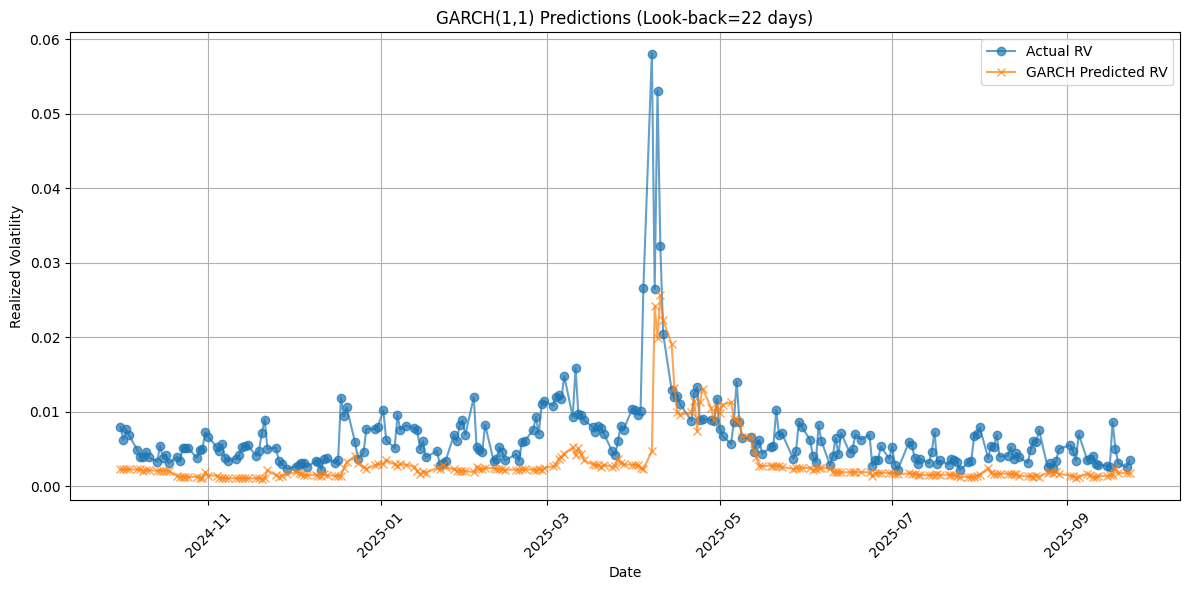

数据长度: 267, 日期范围: 2024-08-29 00:00:00 到 2025-09-23 00:00:00
原始数据范围: 0.002144 - 0.058075
缩放后数据范围: 0.214441 - 5.807533

开始滚动预测，窗口大小: 22天
总预测步数: 245

进度: 0/245


e:\Anaconda\lib\site-packages\arch\univariate\base.py:756: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


进度: 50/245
进度: 100/245
进度: 150/245


e:\Anaconda\lib\site-packages\arch\univariate\base.py:756: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


进度: 200/245


e:\Anaconda\lib\site-packages\arch\univariate\base.py:756: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



模型失败次数统计:
  GARCH: 0/245 (0.0%)
  GJR-GARCH: 0/245 (0.0%)
  TARCH: 0/245 (0.0%)
  EGARCH: 17/245 (6.9%)
  AVGARCH: 0/245 (0.0%)
  FIGARCH: 0/245 (0.0%)

模型评估指标对比 (Model Performance Comparison)
                MSE      RMSE            MAE           MAPE  Correlation          QLIKE  Failed_Rate
GARCH      0.351691  0.593035   4.117745e-01   5.943778e+01     0.626039   1.553364e+00     0.000000
GJR-GARCH  0.373171  0.610877   4.072946e-01   5.873026e+01     0.591231   1.641483e+00     0.000000
TARCH      0.388558  0.623344   4.069148e-01   5.858813e+01     0.559424   1.601319e+00     0.000000
EGARCH          inf       inf  2.736287e+152  4.145085e+154     0.000000  2.570273e+123     6.938776
AVGARCH    0.333975  0.577905   3.971439e-01   5.691588e+01     0.636905   1.425644e+00     0.000000
FIGARCH    0.365463  0.604535   4.071548e-01   5.825413e+01     0.602730   1.521882e+00     0.000000

最佳模型:
  - RMSE最低: AVGARCH (RMSE=0.577905)
  - 相关性最高: AVGARCH (Corr=0.6369)
  - QLIKE最低: AVGARCH (Q

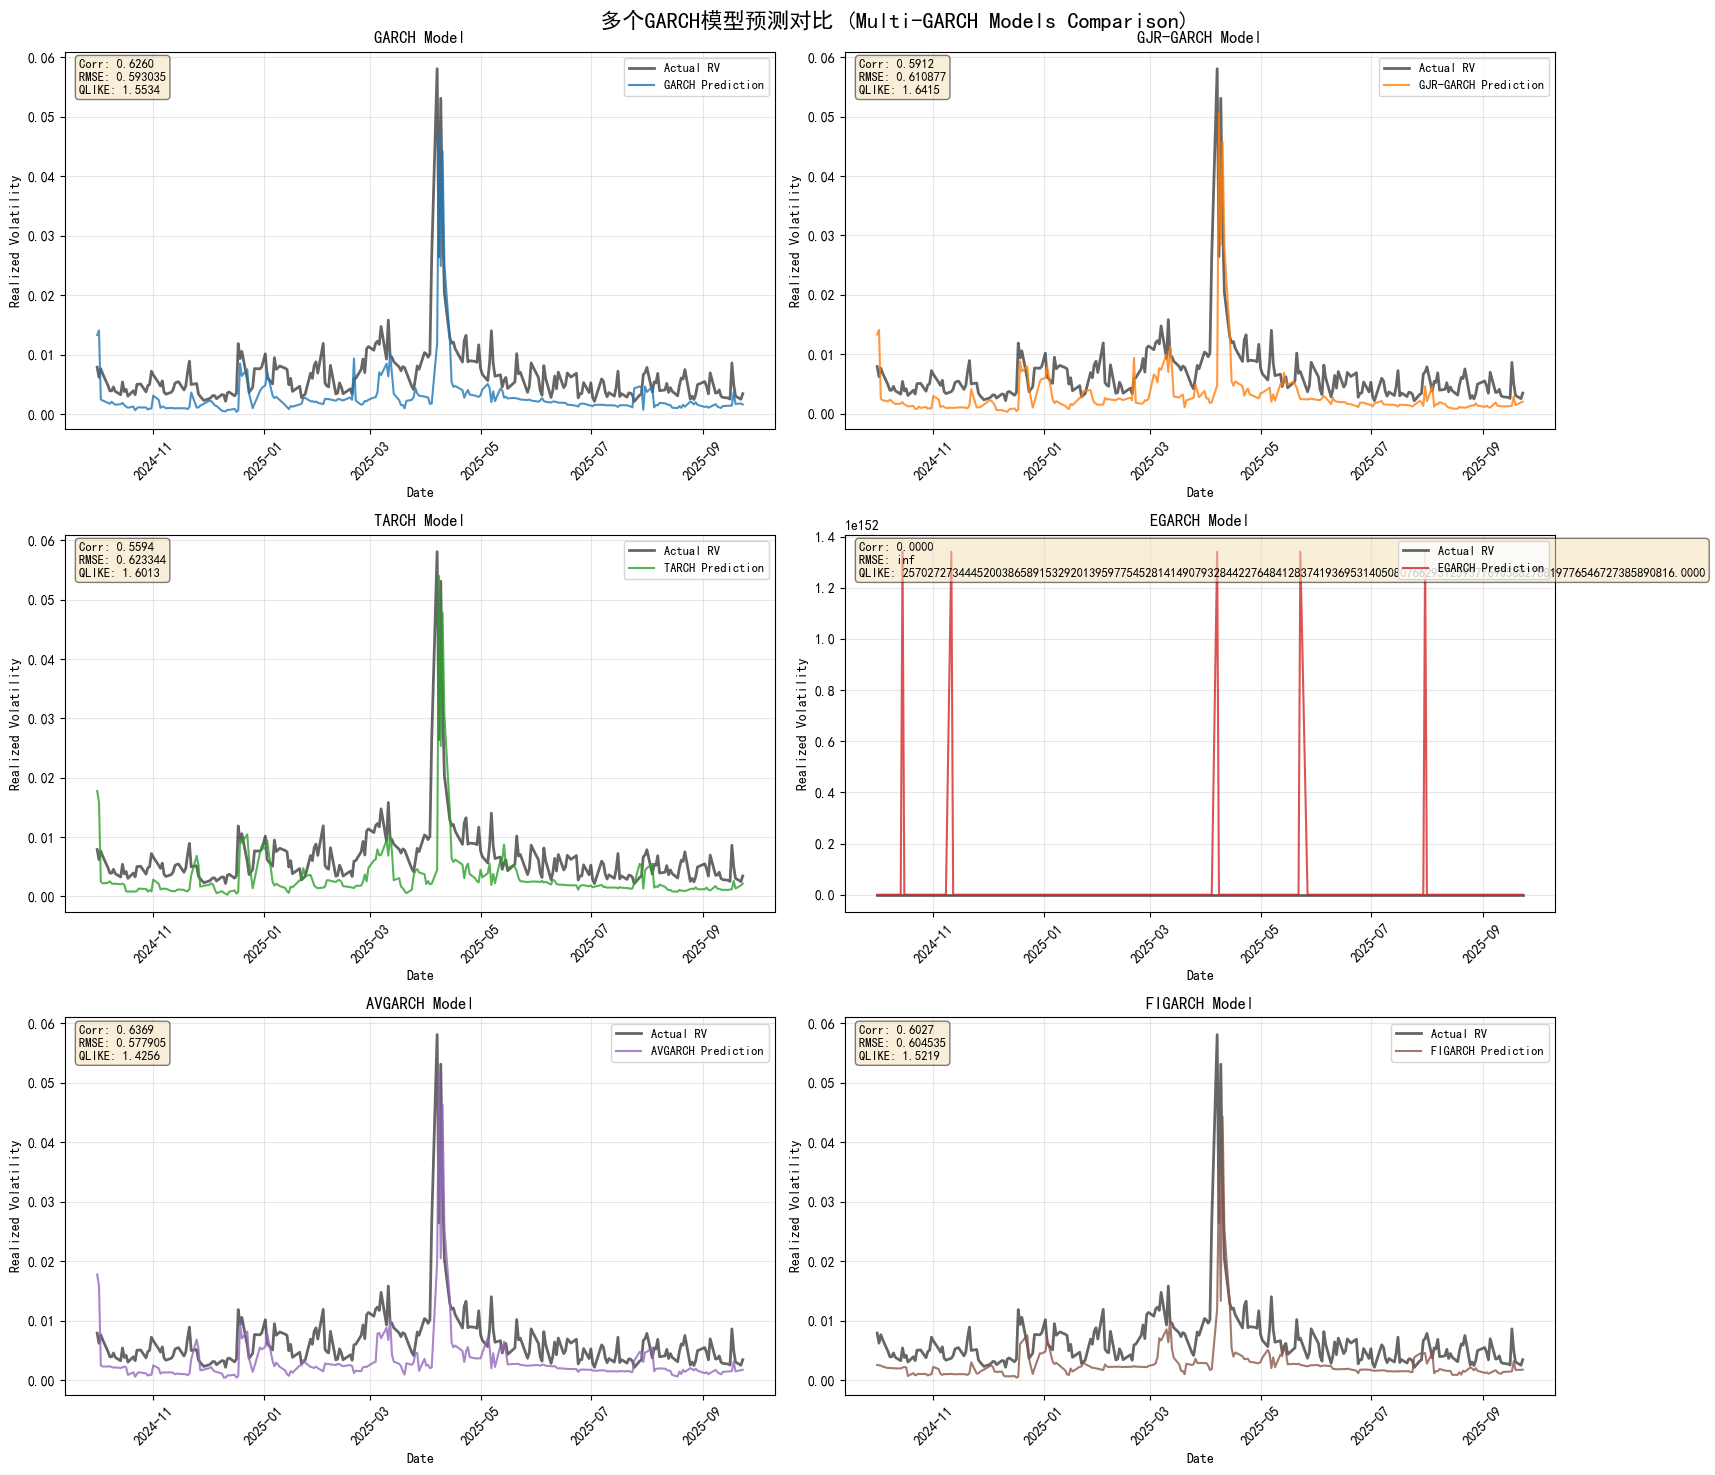

✓ 图表已保存: multi_garch_comparison.png


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from datetime import datetime

# 1. 加载数据
NDX_df = pd.read_csv('../result/SPX_daily_volatility.csv')

# 数据清洗：转换日期，设为索引，使用 realized_volatility
NDX_df['date'] = pd.to_datetime(NDX_df['date'])
NDX_df.set_index('date', inplace=True)
rv = NDX_df['realized_volatility'].dropna()  # RV 序列

print(f"数据长度: {len(rv)}, 日期范围: {rv.index[0]} 到 {rv.index[-1]}")

# 2. 滚动 GARCH 预测函数
def rolling_garch_predict(rv_series, look_back=22):
    predictions = []
    dates = []
    
    for i in range(look_back, len(rv_series)):
        # 训练窗口：过去 look_back 天
        train_rv = rv_series.iloc[i - look_back:i].values
        
        # 拟合 GARCH(1,1)：用 RV 作为输入（代理回报平方）
        model = arch_model(train_rv, vol='Garch', p=1, q=1, dist='normal')
        fitted_model = model.fit(disp='off')  # 无输出，加速
        
        # 预测下一天波动率（horizon=1）
        forecast = fitted_model.forecast(horizon=1)
        pred_vol = np.sqrt(forecast.variance.iloc[-1].item())  # sqrt(σ²) = σ
        
        predictions.append(pred_vol)
        dates.append(rv_series.index[i])  # 预测对应日期
    
    return pd.DataFrame({
        'date': dates,
        'actual_rv': rv_series.iloc[look_back:].values,
        'garch_pred': predictions
    })

# 3. 执行预测
look_back = 22
garch_results = rolling_garch_predict(rv, look_back)

# 保存结果
garch_results.to_csv('../data/garch_predictions.csv', index=False)
print("预测结果保存为 'garch_predictions.csv'")
print(garch_results.head(10))

# 4. 评估指标
mse = np.mean((garch_results['actual_rv'] - garch_results['garch_pred']) ** 2)
rmse = np.sqrt(mse)
print(f"\n评估指标:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"预测 vs 实际相关性: {np.corrcoef(garch_results['actual_rv'], garch_results['garch_pred'])[0,1]:.4f}")

# 5. 可视化
plt.figure(figsize=(12, 6))
plt.plot(garch_results['date'], garch_results['actual_rv'], label='Actual RV', marker='o', alpha=0.7)
plt.plot(garch_results['date'], garch_results['garch_pred'], label='GARCH Predicted RV', marker='x', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.title(f'GARCH(1,1) Predictions (Look-back={look_back} days)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('garch_prediction_plot.png', dpi=300)
plt.show()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体（可选，用于中文标签）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 1. 加载数据
NDX_df = pd.read_csv('../result/SPX_daily_volatility.csv')
NDX_df['date'] = pd.to_datetime(NDX_df['date'])
NDX_df.set_index('date', inplace=True)
rv = NDX_df['realized_volatility'].dropna()

# 数据缩放以避免警告 (参考MultiTransformer代码，将数据乘以100)
rv_scaled = rv * 100  

print(f"数据长度: {len(rv)}, 日期范围: {rv.index[0]} 到 {rv.index[-1]}")
print(f"原始数据范围: {rv.min():.6f} - {rv.max():.6f}")
print(f"缩放后数据范围: {rv_scaled.min():.6f} - {rv_scaled.max():.6f}\n")

# 2. 定义多个GARCH模型函数（修正EGARCH模型定义）
def GARCH_Model(data_series):
    """标准GARCH(1,1)模型，使用t分布"""
    model = arch_model(data_series, dist='t')
    res = model.fit(disp='off')
    cv = res.conditional_volatility
    forecast_var = np.array(res.forecast(horizon=1).variance.dropna())[0][0]
    return model, res, cv, forecast_var

def GJR_GARCH_Model(data_series):
    """GJR-GARCH(1,1)模型，捕捉杠杆效应"""
    model = arch_model(data_series, p=1, o=1, q=1, dist='t')
    res = model.fit(disp='off')
    cv = res.conditional_volatility
    forecast_var = np.array(res.forecast(horizon=1).variance.dropna())[0][0]
    return model, res, cv, forecast_var

def TARCH_Model(data_series):
    """TARCH(1,1)模型，阈值ARCH"""
    model = arch_model(data_series, p=1, o=1, q=1, power=1.0, dist='t')
    res = model.fit(disp='off')
    cv = res.conditional_volatility
    forecast_var = np.array(res.forecast(horizon=1).variance.dropna())[0][0]
    return model, res, cv, forecast_var

def EGARCH_Model(data_series):
    """EGARCH(1,1)模型，指数GARCH - 修正版本"""
    # EGARCH模型需要指定p和q参数，默认为(1,1)
    model = arch_model(data_series, vol="EGARCH", p=1, q=1, dist='t')
    res = model.fit(disp='off', options={'maxiter': 2000})  # 增加迭代次数
    cv = res.conditional_volatility
    forecast_var = np.array(res.forecast(horizon=1).variance.dropna())[0][0]
    return model, res, cv, forecast_var

def AVGARCH_Model(data_series):
    """绝对值GARCH(1,1)模型"""
    model = arch_model(data_series, dist='t', power=1)
    res = model.fit(disp='off', options={'maxiter': 1000})
    cv = res.conditional_volatility
    forecast_var = np.array(res.forecast(horizon=1).variance.dropna())[0][0]
    return model, res, cv, forecast_var

def FIGARCH_Model(data_series):
    """FIGARCH(1,1)模型，长记忆GARCH"""
    model = arch_model(data_series, vol="FIGARCH", p=1, q=1, dist='t')
    res = model.fit(disp='off', options={'maxiter': 2000})
    cv = res.conditional_volatility
    forecast_var = np.array(res.forecast(horizon=1).variance.dropna())[0][0]
    return model, res, cv, forecast_var

# 3. 多模型滚动预测函数
def rolling_multi_garch_predict(rv_series, look_back=22):
    """
    对多个GARCH模型进行滚动预测
    
    参数:
    - rv_series: RV时间序列
    - look_back: 回溯窗口大小
    
    返回:
    - results_df: 包含所有模型预测的DataFrame
    - metrics: 各模型评估指标
    """
    model_functions = {
        'GARCH': GARCH_Model,
        'GJR-GARCH': GJR_GARCH_Model,
        'TARCH': TARCH_Model,
        'EGARCH': EGARCH_Model,
        'AVGARCH': AVGARCH_Model,
        'FIGARCH': FIGARCH_Model
    }
    
    dates = []
    actual_values = []
    predictions = {name: [] for name in model_functions.keys()}
    failed_counts = {name: 0 for name in model_functions.keys()}
    
    print(f"开始滚动预测，窗口大小: {look_back}天")
    print(f"总预测步数: {len(rv_series) - look_back}\n")
    
    for i in range(look_back, len(rv_series)):
        if (i - look_back) % 50 == 0:
            print(f"进度: {i - look_back}/{len(rv_series) - look_back}")
        
        # 训练数据
        train_rv = rv_series.iloc[i - look_back:i].values
        
        # 对每个模型进行预测
        for model_name, model_func in model_functions.items():
            try:
                # 拟合模型并预测
                model, res, cv, forecast_var = model_func(train_rv)
                
                # 条件波动率预测（取平方根得到标准差）
                pred_vol = np.sqrt(forecast_var)
                
                # 检查预测值是否合理
                if np.isnan(pred_vol) or np.isinf(pred_vol) or pred_vol <= 0:
                    raise ValueError(f"Invalid prediction: {pred_vol}")
                
                predictions[model_name].append(pred_vol)
                
            except Exception as e:
                # 如果模型失败，使用前一个预测值或均值
                failed_counts[model_name] += 1
                if (i - look_back) % 100 == 0:  # 减少警告输出频率
                    print(f"警告: {model_name} 在第 {i-look_back} 步失败: {str(e)[:50]}...")
                
                if len(predictions[model_name]) > 0:
                    # 使用前一个预测值
                    predictions[model_name].append(predictions[model_name][-1])
                else:
                    # 使用训练数据的标准差
                    predictions[model_name].append(np.std(train_rv))
        
        dates.append(rv_series.index[i])
        actual_values.append(rv_series.iloc[i])
    
    # 打印失败统计
    print("\n模型失败次数统计:")
    for model_name, count in failed_counts.items():
        total_predictions = len(rv_series) - look_back
        failure_rate = count / total_predictions * 100
        print(f"  {model_name}: {count}/{total_predictions} ({failure_rate:.1f}%)")
    
    # 构建结果DataFrame
    results_df = pd.DataFrame({'date': dates, 'actual_rv': actual_values})
    for model_name, preds in predictions.items():
        results_df[f'{model_name}_pred'] = preds
    
    # 计算评估指标
    metrics = {}
    for model_name in model_functions.keys():
        pred_col = f'{model_name}_pred'
        
        # 基本统计指标
        mse = np.mean((results_df['actual_rv'] - results_df[pred_col]) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(results_df['actual_rv'] - results_df[pred_col]))
        mape = np.mean(np.abs((results_df['actual_rv'] - results_df[pred_col]) / results_df['actual_rv'])) * 100
        corr = np.corrcoef(results_df['actual_rv'], results_df[pred_col])[0, 1]
        
        # QLIKE损失（对数似然）- 对波动率预测更合适的指标
        # 避免除零和对数负数问题
        valid_mask = (results_df[pred_col] > 0) & (results_df['actual_rv'] > 0)
        if valid_mask.sum() > 0:
            qlike = np.mean(
                np.log(results_df.loc[valid_mask, pred_col]) + 
                results_df.loc[valid_mask, 'actual_rv'] / results_df.loc[valid_mask, pred_col]
            )
        else:
            qlike = np.nan
        
        metrics[model_name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'Correlation': corr,
            'QLIKE': qlike,
            'Failed_Rate': failed_counts[model_name] / (len(rv_series) - look_back) * 100
        }
    
    return results_df, metrics

# 4. 执行多模型预测
look_back = 22
results_df, metrics = rolling_multi_garch_predict(rv_scaled, look_back)

# 还原缩放
results_df['actual_rv'] = results_df['actual_rv'] / 100
for col in results_df.columns:
    if col.endswith('_pred'):
        results_df[col] = results_df[col] / 100

# 重新计算指标（基于还原后的数据）
print("\n" + "="*80)
print("模型评估指标对比 (Model Performance Comparison)")
print("="*80)
metrics_df = pd.DataFrame(metrics).T
print(metrics_df.to_string())
print("="*80)

# 找出最佳模型
best_rmse = metrics_df['RMSE'].idxmin()
best_corr = metrics_df['Correlation'].idxmax()
best_qlike_valid = metrics_df.dropna(subset=['QLIKE'])
if len(best_qlike_valid) > 0:
    best_qlike = best_qlike_valid['QLIKE'].idxmin()
else:
    best_qlike = "N/A"

print(f"\n最佳模型:")
print(f"  - RMSE最低: {best_rmse} (RMSE={metrics_df.loc[best_rmse, 'RMSE']:.6f})")
print(f"  - 相关性最高: {best_corr} (Corr={metrics_df.loc[best_corr, 'Correlation']:.4f})")
if best_qlike != "N/A":
    print(f"  - QLIKE最低: {best_qlike} (QLIKE={metrics_df.loc[best_qlike, 'QLIKE']:.4f})")

# 保存结果
results_df.to_csv('../result/multi_garch_predictions.csv', index=False)
metrics_df.to_csv('../result/multi_garch_metrics.csv')
print("\n结果已保存:")
print("- multi_garch_predictions.csv (预测值)")
print("- multi_garch_metrics.csv (评估指标)")

# 5. 可视化部分

# 5.1 时间序列对比图（6个子图）
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('多个GARCH模型预测对比 (Multi-GARCH Models Comparison)', 
             fontsize=16, fontweight='bold')

model_names = ['GARCH', 'GJR-GARCH', 'TARCH', 'EGARCH', 'AVGARCH', 'FIGARCH']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for idx, model_name in enumerate(model_names):
    ax = axes[idx // 2, idx % 2]
    pred_col = f'{model_name}_pred'
    
    # 绘制实际值和预测值
    ax.plot(results_df['date'], results_df['actual_rv'], 
            label='Actual RV', color='black', linewidth=2, alpha=0.6)
    ax.plot(results_df['date'], results_df[pred_col], 
            label=f'{model_name} Prediction', 
            color=colors[idx], linewidth=1.5, alpha=0.8)
    
    # 设置标题和标签
    ax.set_title(f'{model_name} Model', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Realized Volatility', fontsize=10)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # 添加评估指标文本
    corr = metrics[model_name]['Correlation']
    rmse = metrics[model_name]['RMSE']
    qlike = metrics[model_name]['QLIKE']
    ax.text(0.02, 0.98, f'Corr: {corr:.4f}\nRMSE: {rmse:.6f}\nQLIKE: {qlike:.4f}', 
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('multi_garch_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 图表已保存: multi_garch_comparison.png")


## 模型对比

清理后的DataFrame形状: (245, 9)
从第22行开始（日期: 2024-10-01 00:00:00)
DataFrame已创建完成，包含所有数据
         Date        RV    VIX  GARCH_pred  GJR-GARCH_pred  TARCH_pred  \
22 2024-10-01  0.007916  19.26    0.013321        0.013322    0.017771   
23 2024-10-02  0.006213  18.90    0.014086        0.014087    0.015863   
24 2024-10-03  0.007642  20.49    0.002483        0.002483    0.002495   
25 2024-10-04  0.006826  19.21    0.002305        0.002250    0.002202   
26 2024-10-07  0.004808  22.64    0.001919        0.002045    0.002307   

    EGARCH_pred  AVGARCH_pred  FIGARCH_pred  
22     0.010735      0.017767      0.002555  
23     0.006634      0.015864      0.002511  
24     0.078077      0.002496      0.002441  
25     0.007279      0.002303      0.002290  
26     0.007316      0.002306      0.002039  
数据类型检查:
Date              datetime64[ns]
RV                       float64
VIX                      float64
GARCH_pred               float64
GJR-GARCH_pred           float64
TARCH_pred               

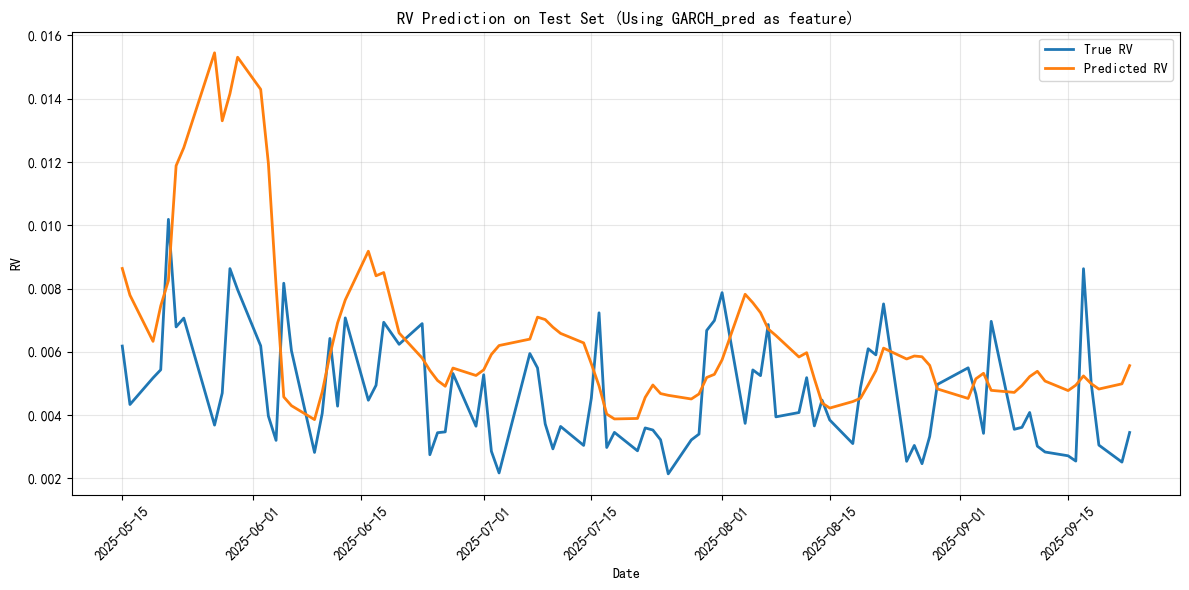


预测结果统计:
         True_RV  Predicted_RV      Error
count  90.000000     90.000000  90.000000
mean    0.004702      0.006416  -0.001714
std     0.001770      0.002578   0.002573
min     0.002144      0.003859  -0.011763
25%     0.003346      0.004916  -0.002656
50%     0.004184      0.005526  -0.001476
75%     0.006013      0.006880  -0.000362
max     0.010187      0.015449   0.003592

训练LSTM模型，使用特征: RV + VIX + GARCH_pred
RV_VIX_GARCH_pred - Epoch 1, Loss: 0.031361
RV_VIX_GARCH_pred - Epoch 101, Loss: 0.004780
RV_VIX_GARCH_pred - Epoch 201, Loss: 0.002887
RV_VIX_GARCH_pred - Epoch 301, Loss: 0.001159
RV_VIX_GARCH_pred - Epoch 401, Loss: 0.000873
RV_VIX_GARCH_pred - Evaluation Metrics:
  MSE: 0.000004
  MAE: 0.001629
  RMSE: 0.002068
  HMSE: 0.295012
  HMAE: 0.400642
  QLIKE: -4.357120

训练LSTM模型，使用特征: RV + VIX + GJR-GARCH_pred
RV_VIX_GJR-GARCH_pred - Epoch 1, Loss: 0.034532
RV_VIX_GJR-GARCH_pred - Epoch 101, Loss: 0.004534
RV_VIX_GJR-GARCH_pred - Epoch 201, Loss: 0.003144
RV_VIX_GJR-GARC

In [7]:
import pandas as pd
import numpy as np

# 读取文件（假设路径为 TGI/result/ 和 TGI/data/，根据您的workspace调整）
spx_df = pd.read_csv('../result/SPX_daily_volatility.csv')
multi_garch_df = pd.read_csv('../result/multi_garch_predictions.csv')
vix_df = pd.read_csv('../data/VIX-20240923-20250923.csv')

# 标准化列名和日期 - 统一使用'date'作为日期列名
spx_df = spx_df.rename(columns={'date': 'date', 'realized_volatility': 'RV'})
vix_df = vix_df.rename(columns={'Date': 'date', 'Close': 'VIX'})
multi_garch_df = multi_garch_df.rename(columns={'date': 'date'})

# 确保所有日期列格式一致
spx_df['date'] = pd.to_datetime(spx_df['date'])
vix_df['date'] = pd.to_datetime(vix_df['date'])
multi_garch_df['date'] = pd.to_datetime(multi_garch_df['date'])

# 选择所需列并合并（基于统一的date列）
df = spx_df[['date', 'RV']].merge(vix_df[['date', 'VIX']], on='date', how='left')
df = df.merge(multi_garch_df, on='date', how='left')

# 找到第一个非NaN的行索引
garch_columns = ['GARCH_pred', 'GJR-GARCH_pred', 'TARCH_pred', 'EGARCH_pred', 'AVGARCH_pred', 'FIGARCH_pred']
first_non_nan_idx = None
for i in range(len(df)):
    if not df[garch_columns].iloc[i].isna().any():
        first_non_nan_idx = i
        break

if first_non_nan_idx is not None:
    # 从第一个非NaN行开始提取数据并创建DataFrame
    df_clean = df.iloc[first_non_nan_idx:].copy()
    
    # 创建包含所有数据的DataFrame
    clean_df = pd.DataFrame({
        'Date': df_clean['date'],
        'RV': df_clean['RV'],
        'VIX': df_clean['VIX'],
        'GARCH_pred': df_clean['GARCH_pred'],
        'GJR-GARCH_pred': df_clean['GJR-GARCH_pred'],
        'TARCH_pred': df_clean['TARCH_pred'],
        'EGARCH_pred': df_clean['EGARCH_pred'],
        'AVGARCH_pred': df_clean['AVGARCH_pred'],
        'FIGARCH_pred': df_clean['FIGARCH_pred']
    })
    
    print(f"清理后的DataFrame形状: {clean_df.shape}")
    print(f"从第{first_non_nan_idx}行开始（日期: {df['date'].iloc[first_non_nan_idx]})")
    print("DataFrame已创建完成，包含所有数据")
    print(clean_df.head())
else:
    print("未找到非NaN的GARCH预测数据")

# 准备数据 - 使用GARCH_pred作为garch_prd，并检查数据类型
print("数据类型检查:")
print(clean_df.dtypes)
print("\n前几行数据:")
print(clean_df.head())

# 确保数值列都是正确的数据类型
numeric_columns = ['RV', 'VIX', 'GARCH_pred', 'GJR-GARCH_pred', 'TARCH_pred', 'EGARCH_pred', 'AVGARCH_pred', 'FIGARCH_pred']
for col in numeric_columns:
    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

# 检查是否有异常值（特别是EGARCH_pred中的684.735）
print("\nEGARCH_pred统计信息:")
print(clean_df['EGARCH_pred'].describe())

# 处理异常值 - 将极端值替换为均值
egarch_mean = clean_df['EGARCH_pred'].mean()
egarch_std = clean_df['EGARCH_pred'].std()
outlier_threshold = egarch_mean + 3 * egarch_std
clean_df.loc[clean_df['EGARCH_pred'] > outlier_threshold, 'EGARCH_pred'] = egarch_mean

# 导入必要的库
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

features = clean_df[['RV', 'VIX', 'GARCH_pred']].values
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

def create_sequences(data, look_back=22):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])  # (22, 3)
        y.append(data[i, 0])  # RV作为目标
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# 转Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# LSTM模型类
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=50, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

torch.save(model.state_dict(), 'lstm_vol_model.pth')
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy().flatten()

# 反标准化
y_test_inv = scaler.inverse_transform(np.column_stack([y_test, np.zeros((len(y_test), 2))]))[:, 0]
y_pred_inv = scaler.inverse_transform(np.column_stack([y_pred_scaled, np.zeros((len(y_pred_scaled), 2))]))[:, 0]

# 指标计算
mse_test = np.mean((y_test - y_pred_scaled)**2)
rmse_unscaled = np.sqrt(np.mean((y_test_inv - y_pred_inv)**2))
print(f'Test MSE (scaled): {mse_test:.4f}')
print(f'Test RMSE (unscaled): {rmse_unscaled:.4f}')

# 提取测试集日期
look_back = 22
test_start_idx = look_back + len(X_train)
y_test_dates = clean_df['Date'].iloc[test_start_idx : test_start_idx + len(X_test)].values

# 可视化
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test_inv, label='True RV', linewidth=2)
plt.plot(y_test_dates, y_pred_inv, label='Predicted RV', linewidth=2)
plt.legend()
plt.title('RV Prediction on Test Set (Using GARCH_pred as feature)')
plt.xlabel('Date')
plt.ylabel('RV')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 保存预测结果到DataFrame
results_df = pd.DataFrame({
    'Date': y_test_dates,
    'True_RV': y_test_inv,
    'Predicted_RV': y_pred_inv,
    'Error': y_test_inv - y_pred_inv
})
print("\n预测结果统计:")
print(results_df.describe())

# 分别创建使用RV+VIX+某一GARCH模型、RV+某一GARCH模型、RV单独、以及RV+VIX的LSTM估计，确保训练参数一致
garch_models = ['GARCH_pred', 'GJR-GARCH_pred', 'TARCH_pred', 'EGARCH_pred', 'AVGARCH_pred', 'FIGARCH_pred']

# 定义统一的训练参数
epochs = 500
learning_rate = 0.001
batch_size = 32
hidden_size = 50
num_layers = 2
dropout = 0.2

# 函数：计算所有评估指标
def calculate_metrics(y_true, y_pred):
    """
    计算所有评估指标
    y_true: 真实值 (RV_t)
    y_pred: 预测值 (δ_t^2)
    """
    # 避免除零错误，添加小的常数
    epsilon = 1e-8
    y_pred = np.maximum(y_pred, epsilon)
    y_true = np.maximum(y_true, epsilon)
    
    # MSE
    mse = np.mean((y_true - y_pred)**2)
    
    # MAE
    mae = np.mean(np.abs(y_true - y_pred))
    
    # RMSE
    rmse = np.sqrt(mse)
    
    # HMSE
    hmse = np.mean((1 - y_pred/y_true)**2)
    
    # HMAE
    hmae = np.mean(np.abs(1 - y_pred/y_true))
    
    # QLIKE
    qlike = np.mean(np.log(y_pred) + y_true/y_pred)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'HMSE': hmse,
        'HMAE': hmae,
        'QLIKE': qlike
    }

# 函数：创建数据加载器
def prepare_data(features, look_back=22, test_size=0.4):
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    X, y = create_sequences(scaled_features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, train_loader, scaler

# 函数：训练和评估模型
def train_and_evaluate_model(model, train_loader, X_test_tensor, y_test_tensor, scaler, model_name, input_size):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if epoch % 100 == 0:
            print(f'{model_name} - Epoch {epoch+1}, Loss: {avg_loss:.6f}')
    
    # 保存模型
    torch.save(model.state_dict(), f'lstm_{model_name}_model.pth')
    
    # 预测
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy().flatten()
    
    # 反标准化
    y_test_flat = y_test_tensor.numpy().flatten()
    y_pred_flat = y_pred_scaled
    # 创建一个与特征维度相同的数组，仅第一列是目标值，其余列为0
    y_test_padded = np.zeros((len(y_test_flat), input_size))
    y_pred_padded = np.zeros((len(y_pred_flat), input_size))
    y_test_padded[:, 0] = y_test_flat
    y_pred_padded[:, 0] = y_pred_flat
    # 反标准化
    y_test_inv = scaler.inverse_transform(y_test_padded)[:, 0]
    y_pred_inv = scaler.inverse_transform(y_pred_padded)[:, 0]
    
    # 计算所有评估指标
    metrics = calculate_metrics(y_test_inv, y_pred_inv)
    
    print(f'{model_name} - Evaluation Metrics:')
    for metric_name, metric_value in metrics.items():
        print(f'  {metric_name}: {metric_value:.6f}')
    
    return y_pred_inv, y_test_inv, metrics

# 存储所有模型的结果
all_results = {}

# 使用RV + VIX + 某一GARCH模型训练LSTM
for garch_model in garch_models:
    print(f"\n{'='*60}")
    print(f"训练LSTM模型，使用特征: RV + VIX + {garch_model}")
    print(f"{'='*60}")
    features_rv_VIX_garch = clean_df[['RV', 'VIX', garch_model]].values
    X_train_rv_VIX_garch, X_test_rv_VIX_garch, y_train_rv_VIX_garch, y_test_rv_VIX_garch, train_loader_rv_VIX_garch, scaler_rv_VIX_garch = prepare_data(features_rv_VIX_garch)
    model_rv_VIX_garch = LSTMModel(input_size=3, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    y_pred_inv_rv_VIX_garch, y_test_inv_rv_VIX_garch, metrics_rv_VIX_garch = train_and_evaluate_model(model_rv_VIX_garch, train_loader_rv_VIX_garch, X_test_rv_VIX_garch, y_test_rv_VIX_garch, scaler_rv_VIX_garch, f"RV_VIX_{garch_model}", input_size=3)
    all_results[f"RV + VIX + {garch_model}"] = metrics_rv_VIX_garch

# 使用RV + 某一GARCH模型训练LSTM
for garch_model in garch_models:
    print(f"\n{'='*60}")
    print(f"训练LSTM模型，使用特征: RV + {garch_model}")
    print(f"{'='*60}")
    features_rv_garch = clean_df[['RV', garch_model]].values
    X_train_rv_garch, X_test_rv_garch, y_train_rv_garch, y_test_rv_garch, train_loader_rv_garch, scaler_rv_garch = prepare_data(features_rv_garch)
    model_rv_garch = LSTMModel(input_size=2, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    y_pred_inv_rv_garch, y_test_inv_rv_garch, metrics_rv_garch = train_and_evaluate_model(model_rv_garch, train_loader_rv_garch, X_test_rv_garch, y_test_rv_garch, scaler_rv_garch, f"RV_{garch_model}", input_size=2)
    all_results[f"RV + {garch_model}"] = metrics_rv_garch

# 使用RV单独训练LSTM
print(f"\n{'='*60}")
print("训练LSTM模型，使用特征: RV")
print(f"{'='*60}")
features_rv = clean_df[['RV']].values
X_train_rv, X_test_rv, y_train_rv, y_test_rv, train_loader_rv, scaler_rv = prepare_data(features_rv)
model_rv = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
y_pred_inv_rv, y_test_inv_rv, metrics_rv = train_and_evaluate_model(model_rv, train_loader_rv, X_test_rv, y_test_rv, scaler_rv, "RV", input_size=1)
all_results["RV"] = metrics_rv

# 使用RV + VIX训练LSTM
print(f"\n{'='*60}")
print("训练LSTM模型，使用特征: RV + VIX")
print(f"{'='*60}")
features_rv_VIX = clean_df[['RV', 'VIX']].values
X_train_rv_VIX, X_test_rv_VIX, y_train_rv_VIX, y_test_rv_VIX, train_loader_rv_VIX, scaler_rv_VIX = prepare_data(features_rv_VIX)
model_rv_VIX = LSTMModel(input_size=2, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
y_pred_inv_rv_VIX, y_test_inv_rv_VIX, metrics_rv_VIX = train_and_evaluate_model(model_rv_VIX, train_loader_rv_VIX, X_test_rv_VIX, y_test_rv_VIX, scaler_rv_VIX, "RV_VIX", input_size=2)
all_results["RV + VIX"] = metrics_rv_VIX

# 使用RV + VIX + 所有GARCH模型训练LSTM
print(f"\n{'='*60}")
print("训练LSTM模型，使用特征: RV + VIX + 所有GARCH模型")
print(f"{'='*60}")
all_features = ['RV', 'VIX'] + garch_models
features_all = clean_df[all_features].values
X_train_all, X_test_all, y_train_all, y_test_all, train_loader_all, scaler_all = prepare_data(features_all)
model_all = LSTMModel(input_size=len(all_features), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
y_pred_inv_all, y_test_inv_all, metrics_all = train_and_evaluate_model(model_all, train_loader_all, X_test_all, y_test_all, scaler_all, "RV_VIX_AllGARCH", input_size=len(all_features))
all_results["RV + VIX + All GARCH"] = metrics_all

print(f"\n{'='*60}")
print("所有组合特征LSTM模型训练完成！")
print(f"{'='*60}")

# 创建综合结果表格
results_summary = []
for model_name, metrics in all_results.items():
    row = {'Model': model_name}
    row.update(metrics)
    results_summary.append(row)

results_df = pd.DataFrame(results_summary)
print("\n所有模型的评估指标汇总:")
print("="*100)
print(results_df.to_string(index=False, float_format='%.6f'))

# 找出每个指标的最佳模型
print("\n各指标最佳模型:")
print("="*50)
for metric in ['MSE', 'MAE', 'RMSE', 'HMSE', 'HMAE', 'QLIKE']:
    if metric == 'QLIKE':
        # QLIKE越小越好
        best_idx = results_df[metric].idxmin()
    else:
        # 其他指标都是越小越好
        best_idx = results_df[metric].idxmin()
    best_model = results_df.loc[best_idx, 'Model']
    best_value = results_df.loc[best_idx, metric]
    print(f"{metric:6s}: {best_model} ({best_value:.6f})")
